<a href="https://colab.research.google.com/github/BetaPrimePsi/BetaPrimePsi/blob/main/F_JEPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium gym-trading-env stable-baselines3 torch pandas yfinance
!pip install gym-anytrading

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.1/641.1 kB 30.9 MB/s eta 0:00:00
  Attempting uninstall: flask
    Found existing installation: Flask 3.1.2
    Uninstalling Flask-3.1.2:
      Successfully uninstalled Flask-3.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 4.1 MB/s eta 0:00:00


# Extracting and preprocessing data

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

TICKERS = ["SPY", "QQQ", "IWM", "TLT", "HYG", "GLD", "USO",
           "UUP", "XLF", "XLK", "XLE", "XLY", "XLP"]

def load_multi_asset(start="2015-01-01", end="2025-01-01"):
    data = yf.download(TICKERS, start=start, end=end, group_by='ticker')

    # Build combined dataframe
    rows = []
    for ticker in TICKERS:
        df = data[ticker].copy()
        df.columns = [f"{ticker}_{col}" for col in df.columns]

        # Features
        df[f"{ticker}_pct"] = df[f"{ticker}_Close"].pct_change()
        df[f"{ticker}_sma5"] = df[f"{ticker}_Close"].rolling(5).mean()
        df[f"{ticker}_ema10"] = df[f"{ticker}_Close"].ewm(10).mean()
        df[f"{ticker}_vol10"] = df[f"{ticker}_Close"].pct_change().rolling(10).std()

        rows.append(df)

    # align by index
    full_df = pd.concat(rows, axis=1)
    full_df = full_df.dropna()

    return full_df

In [ ]:
df = load_multi_asset()


/tmp/ipython-input-2340905404.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKERS, start=start, end=end, group_by='ticker')
[                       0%                       ]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[*******               15%                       ]  2 of 13 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[***********           23%                       ]  3 

In [ ]:
split = int(len(df) * 0.8)
df_train = df.iloc[:split].reset_index(drop=True)
df_val   = df.iloc[split:].reset_index(drop=True)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df_train.values)   # ONLY fit on train

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


MinMaxScaler()

In [ ]:
train_scaled = scaler.transform(df_train.values)
val_scaled   = scaler.transform(df_val.values)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
arr_train = train_scaled.astype(np.float32)
arr_val   = val_scaled.astype(np.float32)


In [ ]:
print(df.shape)

(2506, 117)


In [ ]:
INPUT_DIM = df_train.shape[1]
print("JEPA Input Dim =", INPUT_DIM)

JEPA Input Dim = 117


# Building the training and validation RL envs

In [ ]:
import gymnasium as gym
from gymnasium import spaces

class MultiAssetEnv(gym.Env):
    def __init__(self, df, data_array, window=30, start_balance=1000, deterministic=False):
        super().__init__()

        self.df = df
        self.data = data_array
        self.window = window
        self.start_balance = start_balance
        self.deterministic = deterministic
        self.max_step = len(df) - 1

        # SPY close price for trading
        self.spy_price = df["SPY_Close"].values

        # Action space: 0=hold, 1=buy, 2=sell
        self.action_space = spaces.Discrete(3)

        # Observation: (window, feature_dim)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(window, data_array.shape[1]),
            dtype=np.float32
        )

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        if self.deterministic:
            self.step_i = self.window
        else:
            self.step_i = np.random.randint(self.window, self.max_step-5)

        self.balance = self.start_balance
        self.shares = 0
        self.net_worth = self.start_balance

        return self._obs(), {"net_worth": self.net_worth}

    def _obs(self):
        return self.data[self.step_i - self.window : self.step_i]

    def step(self, action):
        self.step_i += 1
        done = self.step_i >= self.max_step

        price = float(self.spy_price[self.step_i])

        # --- Simple trading logic ---
        if action == 1:  # buy
            if self.balance >= price:
                self.balance -= price
                self.shares += 1

        elif action == 2:  # sell
            if self.shares > 0:
                self.shares -= 1
                self.balance += price

        new_worth = self.balance + self.shares * price
        reward = new_worth - self.net_worth
        self.net_worth = new_worth

        # drawdown rule
        if self.net_worth < 0.7 * self.start_balance:
            done = True
            reward -= self.start_balance

        return self._obs(), reward, done, False, {"net_worth": self.net_worth}


In [ ]:
env_train = MultiAssetEnv(df_train, arr_train, deterministic=False, window = 30)
env_val   = MultiAssetEnv(df_val,   arr_val,   deterministic=True, window=30)


# Defining the JEPA architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

class JEPA(nn.Module):
    def __init__(self, input_dim, d_model=64, seq_len=30, heads=2, layers=1):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos = nn.Parameter(torch.randn(1, seq_len, d_model))

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=heads,
            dim_feedforward=128,
            batch_first=True
        )

        # Online encoder
        self.encoder_online = nn.TransformerEncoder(enc_layer, num_layers=layers)

        # EMA Target encoder
        self.encoder_target = copy.deepcopy(self.encoder_online)
        for p in self.encoder_target.parameters():
            p.requires_grad = False

        # Predictor: z_t + action → z_t+1_pred
        self.predictor = nn.Sequential(
            nn.Linear(d_model + 3, 128),
            nn.ReLU(),
            nn.Linear(128, d_model)
        )

    def encode_online(self, x, mask_prob=0.3):
        if mask_prob > 0:
            B, T, F = x.shape
            mask = (torch.rand(B, T, device=x.device) < mask_prob).unsqueeze(-1)
            x = x.masked_fill(mask, 0.0)

        h = self.input_proj(x) + self.pos
        z = self.encoder_online(h)
        return z[:, -1, :]  # last token

    @torch.no_grad()
    def encode_target(self, x):
        h = self.input_proj(x) + self.pos
        z = self.encoder_target(h)
        return z[:, -1, :]

    def update_ema(self, tau=0.99):
        for p_tgt, p_src in zip(self.encoder_target.parameters(), self.encoder_online.parameters()):
            p_tgt.data.mul_(tau).add_(p_src.data, alpha=1 - tau)

    def predict_next_latent(self, z_t, a):
        a_onehot = F.one_hot(a.long(), num_classes=3).float()
        inp = torch.cat([z_t, a_onehot], dim=1)
        return self.predictor(inp)


# Mounting drive to keep saving and loading over runtimes

In [ ]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
# Create a dedicated directory for your project checkpoints
CHECKPOINT_DIR = '/content/gdrive/MyDrive/ACL_JEPA_Project/'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"Checkpoints will be saved to: {CHECKPOINT_DIR}")

Mounted at /content/gdrive
Checkpoints will be saved to: /content/gdrive/MyDrive/ACL_JEPA_Project/


# Helpers for visualization

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def get_attention_weights(jepa, obs_tensor):
    """
    Get self-attention weights from the first layer of the online encoder.
    """
    jepa.eval()

    with torch.no_grad():
        # projected input + positional encoding
        x = jepa.input_proj(obs_tensor) + jepa.pos

        layer = jepa.encoder_online.layers[0]

        # Norm + attention
        normed = layer.norm1(x)
        _, attn_weights = layer.self_attn(
            normed, normed, normed,
            need_weights=True,
            average_attn_weights=False
        )

        # shape: [batch, heads, seq, seq]
        attn = attn_weights.mean(dim=1)[0].cpu().numpy()  # average over heads

    jepa.train()
    return attn[-1], attn


In [ ]:
def plot_attention_sequence(attn_seq, df_slice, title):
    """
    df_slice must correspond to the window of data (window=30 rows).
    We extract SPY_Close for price context.
    """
    import matplotlib.pyplot as plt

    spy = df_slice["SPY_Close"].values
    t = np.arange(len(spy))

    attn_seq = np.array(attn_seq)
    attn_smoothed = pd.Series(attn_seq).rolling(3, min_periods=1).mean()

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Price
    ax1.plot(t, spy, color="blue", label="SPY Close")
    ax1.set_ylabel("SPY Price", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")

    # Attention
    ax2 = ax1.twinx()
    ax2.bar(t, attn_smoothed, color="red", alpha=0.5)
    ax2.set_ylabel("Attention Weight", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    plt.title(title)
    plt.show()


In [ ]:
def plot_attention_map(attn_map, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(attn_map, cmap="YlGnBu")
    plt.title(title)
    plt.xlabel("Key (Past)")
    plt.ylabel("Query")
    plt.show()


# Initialization and Training

In [ ]:
import torch.optim as optim
from torch.distributions import Categorical

# Init Model
jepa = JEPA(input_dim=INPUT_DIM)


# Policy Head (Actor-Critic) attached to the JEPA Encoder
actor_head = nn.Linear(64, 3) # Output: 3 actions
critic_head = nn.Linear(64, 1) # Output: Value

In [ ]:
params = list(jepa.parameters()) + \
         list(actor_head.parameters()) + \
         list(critic_head.parameters())
optimizer = torch.optim.Adam(params, lr=1e-4)

In [ ]:
import os
import torch

def save_checkpoint(path, epoch, jepa, actor_head, critic_head, optimizer, best_val_reward):
    ckpt = {
        "epoch": epoch,
        "best_val_reward": best_val_reward,

        # JEPA encoders
        "encoder_online": jepa.encoder_online.state_dict(),
        "encoder_target": jepa.encoder_target.state_dict(),
        "input_proj": jepa.input_proj.state_dict(),
        "pos": jepa.pos.detach().cpu(),
        "predictor": jepa.predictor.state_dict(),

        # Actor–critic heads
        "actor_head": actor_head.state_dict(),
        "critic_head": critic_head.state_dict() if critic_head is not None else None,

        # Optimizer
        "optimizer": optimizer.state_dict(),
    }

    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(ckpt, path)
    print(f"✓ Saved checkpoint → {path}")


In [ ]:
def load_checkpoint(path, jepa, actor_head, critic_head, optimizer, device="cpu"):
    if not os.path.exists(path):
        print(f"⚠ No checkpoint found at {path}, starting fresh.")
        return 0, -float("inf")   # epoch, best_val_reward

    ckpt = torch.load(path, map_location=device)

    # Load JEPA parts
    jepa.encoder_online.load_state_dict(ckpt["encoder_online"])
    jepa.encoder_target.load_state_dict(ckpt["encoder_target"])
    jepa.input_proj.load_state_dict(ckpt["input_proj"])
    jepa.predictor.load_state_dict(ckpt["predictor"])
    jepa.pos.data = ckpt["pos"].to(device)

    # Load actor/critic
    actor_head.load_state_dict(ckpt["actor_head"])
    if critic_head is not None and ckpt["critic_head"] is not None:
        critic_head.load_state_dict(ckpt["critic_head"])

    # Load optimizer
    optimizer.load_state_dict(ckpt["optimizer"])

    start_epoch = ckpt["epoch"] + 1
    best_val_reward = ckpt.get("best_val_reward", -float("inf"))

    print(f"✓ Loaded checkpoint from {path} | Resuming at epoch {start_epoch}")
    return start_epoch, best_val_reward


In [ ]:
CHECKPOINT_DIR = "/content/gdrive/MyDrive/ACL_JEPA_Project/"
BEST_MODEL = CHECKPOINT_DIR + "best_model.pth"
LAST_MODEL = CHECKPOINT_DIR + "last_model.pth"

In [ ]:
start_epoch, best_val = load_checkpoint(
    LAST_MODEL, jepa, actor_head, critic_head, optimizer
)

In [ ]:
def validate_model(env_val, jepa, actor_head, runs=5, device="cpu"):
    """
    Runs several episodes on the validation environment and returns the mean reward.
    Uses the JEPA encoder to produce state latents for the policy head.
    """
    jepa.eval()
    actor_head.eval()

    rewards_all = []

    for _ in range(runs):
        obs, info = env_val.reset()
        done = False
        total_reward = 0.0

        while not done:
            # Convert obs to tensor
            obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)

            # Encode state using online encoder
            with torch.no_grad():
                z_t = jepa.encode_online(obs_tensor)  # [1, d_model]

                # Actor head chooses action
                logits = actor_head(z_t)
                probs = F.softmax(logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                action = dist.sample().item()

            # Step the environment
            obs, reward, done, truncated, info = env_val.step(action)
            total_reward += reward

        rewards_all.append(total_reward)

    jepa.train()
    actor_head.train()

    return float(np.mean(rewards_all))

In [ ]:
val_data_length = len(df_val)
print(f"Validation data length: {val_data_length} days.")

Validation data length: 502 days.


In [ ]:
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# Hyperparameters
CHECKPOINT_DIR = '/content/gdrive/MyDrive/ACL_JEPA_Project/'

best_val = -np.inf
PATIENCE_COUNTER = 0
PATIENCE_LIMIT = 50 # Stop if validation reward doesn't improve for 50 epochs
start_epoch = 0
EPOCHS = 500
JEPA_BETA = 0.5 # Weighting for the auxiliary JEPA loss
GAMMA = 0.99 # Discount factor

# Training loop 1 (old)

Epoch 0: Train Reward 494.52 | VAL Reward 349.50 | JEPA Loss 1.1417 | Policy Loss 0.0059 | Critic Loss 1.0127
✓ Saved checkpoint → /content/gdrive/MyDrive/ACL_JEPA_Project/best_model.pth
✓ Saved checkpoint → /content/gdrive/MyDrive/ACL_JEPA_Project/last_model.pth
Epoch 10: Train Reward 571.94 | VAL Reward 334.21 | JEPA Loss 1.0607 | Policy Loss -0.0231 | Critic Loss 0.9677
Epoch 20: Train Reward 177.76 | VAL Reward 341.74 | JEPA Loss 0.9703 | Policy Loss -0.0137 | Critic Loss 0.9275
Epoch 30: Train Reward 194.86 | VAL Reward 322.31 | JEPA Loss 0.8854 | Policy Loss 0.0133 | Critic Loss 0.8786
Epoch 40: Train Reward 243.01 | VAL Reward 316.70 | JEPA Loss 0.8039 | Policy Loss -0.0044 | Critic Loss 0.8400
Epoch 50: Train Reward 144.86 | VAL Reward 303.43 | JEPA Loss 0.7100 | Policy Loss 0.0054 | Critic Loss 0.7758
✓ Saved checkpoint → /content/gdrive/MyDrive/ACL_JEPA_Project/last_model.pth
Epoch 60: Train Reward 40.67 | VAL Reward 278.88 | JEPA Loss 0.6146 | Policy Loss -0.0011 | Critic Lo

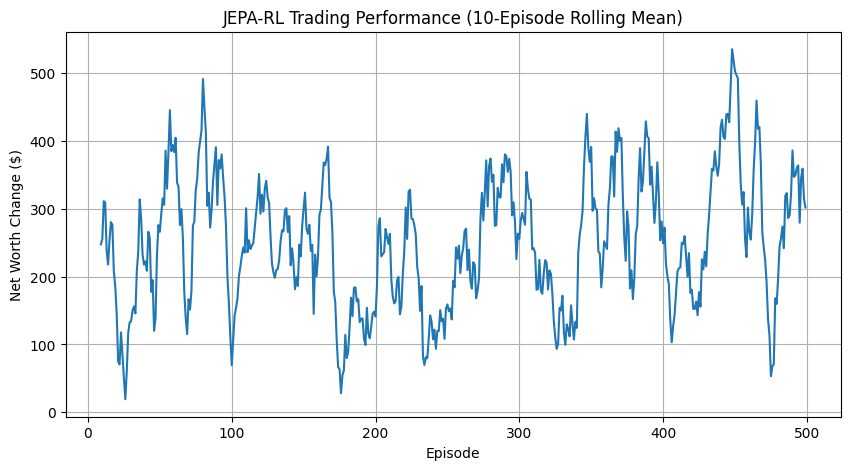

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Training Loop
history_rewards = []
env_reset_count = 0

for epoch in range(start_epoch, EPOCHS):
    obs, _ = env_train.reset()
    env_reset_count += 1
    done = False
    total_reward = 0

    # We will accumulate losses over one episode for a single update (Simplified Policy Gradient)
    log_probs = []
    rewards = []
    jepa_losses = []
    values = []

    while not done:
        # Prepare Observation and Get State Vector
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0) # [1, 30, 8]
        z_online = jepa.encode_online(obs_tensor)
        value = critic_head(z_online)   # shape [1,1] or [1]
        values.append(value.squeeze())

        # Choose Action (Actor)
        logits = actor_head(z_online)
        dist = Categorical(logits=F.softmax(logits, dim=-1))
        action = dist.sample()
        action_onehot = F.one_hot(action, num_classes=3).float()
        log_prob = dist.log_prob(action)

        # Step Environment and Get Next Observation
        next_obs, reward, done, truncated, info = env_train.step(action.item())

        # Calculate JEPA Loss (The Paper Contribution)

        # Target: Encode the ACTUAL next observation
        next_obs_tensor = torch.FloatTensor(next_obs).unsqueeze(0)

        with torch.no_grad():
            z_target = jepa.encode_target(next_obs_tensor)

        z_pred = jepa.predict_next_latent(z_online, action)

        L_JEPA = F.mse_loss(z_pred, z_target)
        jepa_losses.append(L_JEPA)

        # --- 5. Accumulate RL Data ---
        log_probs.append(log_prob)
        rewards.append(reward)
        obs = next_obs
        total_reward += reward

    # Policy Update (Simplified Policy Gradient)

    # Calculate discounted rewards (G_t)
    G = 0
    returns = []

    for r in rewards[::-1]:
        G = r + GAMMA * G
        returns.insert(0, G)
    returns = torch.tensor(returns)
    # Simple Baselines: Subtract the mean of returns (simplification for stability)
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)

    # Calculate Total Loss
    policy_loss = []
    values_tensor = torch.stack(values)
    advantages = returns - values_tensor.detach()
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    policy_loss = -(advantages * torch.stack(log_probs)).sum()

    critic_loss = F.mse_loss(values_tensor, returns)

    L_JEPA_total = torch.stack(jepa_losses).mean()

    total_loss = 50* policy_loss + critic_loss + JEPA_BETA * L_JEPA_total


    # Backpropagate
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    jepa.update_ema()

    history_rewards.append(total_reward)

    if epoch % 10 == 0:
        # Run validation every 10 epochs
        val_reward = validate_model(env_val, jepa, actor_head, runs=5)

        print(f"Epoch {epoch}: Train Reward {total_reward:,.2f} | VAL Reward {val_reward:,.2f} | JEPA Loss {L_JEPA_total.item():.4f} | Policy Loss {policy_loss.item():.4f} | Critic Loss {critic_loss.item():.4f}")

        # Check for early stopping
        if val_reward > best_val:
            best_val = val_reward
            save_checkpoint(BEST_MODEL, epoch, jepa, actor_head, critic_head, optimizer, best_val)

        else:
            PATIENCE_COUNTER += 1
            if PATIENCE_COUNTER >= PATIENCE_LIMIT:
                print(f"🛑 Early stopping triggered at Epoch {epoch}. Validation reward hasn't improved for {PATIENCE_LIMIT} epochs.")
                break # Stop the training loop

    # Save checkpoint every 50 epochs
    if epoch % 50 == 0:
        save_checkpoint(LAST_MODEL, epoch, jepa, actor_head, critic_head, optimizer, best_val)


# Plotting the results
plt.figure(figsize=(10, 5))
pd.Series(history_rewards).rolling(10).mean().plot(title="JEPA-RL Trading Performance (10-Episode Rolling Mean)")
plt.xlabel("Episode")
plt.ylabel("Net Worth Change ($)")
plt.grid(True)
plt.show()

# Training loop 2 (new)

In [ ]:
# Metrics we will plot later
train_rewards = []
val_rewards = []
jepa_curve = []
policy_curve = []
critic_curve = []

for epoch in range(start_epoch, EPOCHS):

    # Reset training episode
    obs, _ = env_train.reset()
    done = False
    total_reward = 0

    log_probs = []
    rewards = []
    jepa_losses = []
    values = []

    # -----------------------------
    #  Episode rollout
    # -----------------------------
    while not done:
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0)

        # JEPA encoding
        z_online = jepa.encode_online(obs_tensor)
        value = critic_head(z_online)
        values.append(value.squeeze())

        # RL policy step
        logits = actor_head(z_online)
        dist = Categorical(logits=F.softmax(logits, dim=-1))
        action = dist.sample()
        log_prob = dist.log_prob(action)

        next_obs, reward, done, truncated, info = env_train.step(action.item())
        total_reward += reward

        # JEPA predictive loss
        next_obs_t = torch.FloatTensor(next_obs).unsqueeze(0)

        with torch.no_grad():
            z_target = jepa.encode_target(next_obs_t)

        z_pred = jepa.predict_next_latent(z_online, action)
        L_JEPA = F.mse_loss(z_pred, z_target)
        jepa_losses.append(L_JEPA)

        # RL bookkeeping
        log_probs.append(log_prob)
        rewards.append(reward)

        obs = next_obs

    # -----------------------------
    # Policy Gradient Update
    # -----------------------------
    G = 0
    returns = []
    for r in rewards[::-1]:
        G = r + GAMMA * G
        returns.insert(0, G)
    returns = torch.tensor(returns, dtype=torch.float32)

    # Advantage normalization
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)

    values_tensor = torch.stack(values)
    advantages = returns - values_tensor.detach()
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-9)

    policy_loss = -(advantages * torch.stack(log_probs)).sum()
    critic_loss = F.mse_loss(values_tensor, returns)
    L_JEPA_total = torch.stack(jepa_losses).mean()

    total_loss = 50 * policy_loss + critic_loss + JEPA_BETA * L_JEPA_total

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    jepa.update_ema()

    # -----------------------------
    # Store metrics
    # -----------------------------
    train_rewards.append(total_reward)
    jepa_curve.append(L_JEPA_total.item())
    policy_curve.append(policy_loss.item())
    critic_curve.append(critic_loss.item())

    # -----------------------------
    # Validation
    # -----------------------------
    if epoch % 10 == 0:
        val_reward = validate_model(env_val, jepa, actor_head, runs=5)
        val_rewards.append(val_reward)

        print(f"Epoch {epoch}: Train={total_reward:.2f} | Val={val_reward:.2f} "
              f"| JEPA={L_JEPA_total.item():.4f} | Policy={policy_loss.item():.4f} "
              f"| Critic={critic_loss.item():.4f}")

        if val_reward > best_val:
            best_val = val_reward
            save_checkpoint(BEST_MODEL, epoch, jepa, actor_head, critic_head, optimizer, best_val)
        else:
            PATIENCE_COUNTER += 1
            if PATIENCE_COUNTER >= PATIENCE_LIMIT:
                print("Early stopping due to no improvement.")
                break

    if epoch % 50 == 0:
        save_checkpoint(LAST_MODEL, epoch, jepa, actor_head, critic_head, optimizer, best_val)


Epoch 0: Train=145.33 | Val=169.36 | JEPA=1.1184 | Policy=0.0068 | Critic=1.0538
✓ Saved checkpoint → /content/gdrive/MyDrive/ACL_JEPA_Project/best_model.pth
✓ Saved checkpoint → /content/gdrive/MyDrive/ACL_JEPA_Project/last_model.pth
Epoch 10: Train=0.93 | Val=160.41 | JEPA=1.0121 | Policy=-0.0000 | Critic=0.9877
Epoch 20: Train=501.85 | Val=235.43 | JEPA=0.9110 | Policy=0.0066 | Critic=0.9689
✓ Saved checkpoint → /content/gdrive/MyDrive/ACL_JEPA_Project/best_model.pth
Epoch 30: Train=-68.00 | Val=222.33 | JEPA=0.8080 | Policy=-0.0020 | Critic=0.9841
Epoch 40: Train=262.16 | Val=207.54 | JEPA=0.7230 | Policy=0.0059 | Critic=0.9077
Epoch 50: Train=-13.88 | Val=264.75 | JEPA=0.6299 | Policy=0.0026 | Critic=0.8877
✓ Saved checkpoint → /content/gdrive/MyDrive/ACL_JEPA_Project/best_model.pth
✓ Saved checkpoint → /content/gdrive/MyDrive/ACL_JEPA_Project/last_model.pth
Epoch 60: Train=-62.46 | Val=246.88 | JEPA=0.5339 | Policy=-0.0003 | Critic=1.0240
Epoch 70: Train=365.09 | Val=196.41 | JEP

In [ ]:
# After training ends
train_rewards = np.array(train_rewards)
val_rewards = np.array(val_rewards)
jepa_curve = np.array(jepa_curve)
policy_curve = np.array(policy_curve)
critic_curve = np.array(critic_curve)


# Eval JEPA

In [ ]:
def compute_sharpe(returns):
    mean_r = np.mean(returns)
    std_r = np.std(returns) + 1e-9
    return mean_r / std_r


In [ ]:
def compute_max_drawdown(reward_curve):
    cum = np.cumsum(reward_curve)
    peak = np.maximum.accumulate(cum)
    drawdown = (cum - peak)
    max_dd = drawdown.min()
    return max_dd


In [ ]:
sharpe = compute_sharpe(train_rewards)
max_dd = compute_max_drawdown(train_rewards)

print("Sharpe Ratio =", sharpe)
print("Max Drawdown =", max_dd)
print("Mean Reward =", np.mean(train_rewards))
print("Val Mean Reward =", np.mean(val_rewards))


Sharpe Ratio = 0.9150021656741417
Max Drawdown = -1324.8340148925781
Mean Reward = 250.7199879760742
Val Mean Reward = 282.82497131347657


# Eval Random

In [ ]:
def evaluate_random(env, episodes=20):
    results = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        total = 0
        while not done:
            action = np.random.randint(0, 3)
            obs, reward, done, truncated, info = env.step(action)
            total += reward
        results.append(total)
    return np.array(results)

rand_results = evaluate_random(env_val)
print("Random Policy Mean Reward =", rand_results.mean())
print("Random Sharpe =", compute_sharpe(rand_results))
print("Random Max DD =", compute_max_drawdown(rand_results))


NameError: name 'env_val' is not defined

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 1, figsize=(5, 8))

# ---- 1. Train Reward ----
axes[0].plot(train_rewards, label="Train Reward")
axes[0].set_title("Reward Curves")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Training Reward")

# ---- 2. Val Reward ----
axes[1].plot(val_rewards, label="Validation Reward", color="orange")
axes[1].set_xlabel("Epoch (every 10)")
axes[1].set_ylabel("Validation Reward")

In [ ]:

fig, axes = plt.subplots(1, 1, figsize=(7.5, 5))
# ---- 3. JEPA Loss ----
axes.plot(jepa_curve, color="purple")
axes.set_title("JEPA Predictive Loss Over Time")
axes.set_xlabel("Episode")
axes.set_ylabel("Loss")


plt.tight_layout()
plt.show()



In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def extract_latents(env, jepa, max_steps=1000):
    latents = []

    obs, _ = env.reset()
    done = False
    steps = 0

    while not done and steps < max_steps:
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            z = jepa.encode_online(obs_tensor)
        latents.append(z.squeeze().cpu().numpy())

        obs, reward, done, truncated, _ = env.step(0)  # action doesn't matter for extraction
        steps += 1

    return np.array(latents)

latents = extract_latents(env_val, jepa)
print("Latents shape:", latents.shape)

# ---- KMeans ----
kmeans = KMeans(n_clusters=5).fit(latents)
labels = kmeans.labels_

# ---- PCA for viz ----
pca = PCA(n_components=2)
proj = pca.fit_transform(latents)

plt.figure(figsize=(7,5))
plt.scatter(proj[:,0], proj[:,1], c=labels, cmap="viridis", s=10)
plt.title("JEPA Latent Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()


In [ ]:
def compute_attention_stats(jepa, data_array):
    attn_means = []
    attn_stds = []

    for i in range(100):  # sample 100 windows
        idx = np.random.randint(30, len(data_array))
        window = data_array[idx-30:idx]
        obs = torch.tensor(window, dtype=torch.float32).unsqueeze(0)

        _, attn = get_attention_weights(jepa, obs)
        attn_last = attn[0].mean(0)  # average over heads

        attn_means.append(attn_last)
        attn_stds.append(attn_last)

    attn_means = np.vstack(attn_means)
    attn_stds = np.vstack(attn_stds)

    mean_vec = attn_means.mean(axis=0)
    std_vec = attn_stds.std(axis=0)

    return mean_vec, std_vec

mean_attention, std_attention = compute_attention_stats(jepa, arr_val)

print("Mean attention:", mean_attention)
print("Std attention:", std_attention)


In [ ]:
test_obs, _ = env_val.reset()
test_obs_tensor = torch.FloatTensor(test_obs).unsqueeze(0)

# Get the Close price sequence for context (last column of the observation)
price_sequence = test_obs[:, 3] # Index 3 is Close Price (OHLCV...)

# Get the attention weights
attn_sequence, attn_map = get_attention_weights(jepa, test_obs_tensor)

# Plot the Final Token Attention over the Price Sequence
plot_attention_sequence(
    attn_sequence,
    price_sequence,
    title="JEPA Attention on Price Sequence (Final Token Query)"
)

# Plot the full attention map
plot_attention_map(
    attn_map,
    title="Full Transformer Attention Matrix"
)

In [ ]:
import numpy as np
import torch

def sample_attention_variability(env, jepa, num_samples=100, device="cpu"):
    attn_list = []

    for _ in range(num_samples):

        obs, _ = env.reset()
        obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)

        final_attn, _ = get_attention_weights(jepa, obs_tensor)  # final_attn: [seq_len]
        attn_list.append(final_attn)

    attn_arr = np.stack(attn_list, axis=0)  # [num_samples, seq_len]

    mean_attn = attn_arr.mean(axis=0)
    std_attn = attn_arr.std(axis=0)

    return mean_attn, std_attn, attn_arr


In [ ]:
mean_attn, std_attn, attn_arr = sample_attention_variability(env_val, jepa, num_samples=100)

print("Mean attention per position:", mean_attn)
print("Std dev per position:", std_attn)
print("Overall std:", std_attn.mean())


NameError: name 'env_val' is not defined

In [ ]:
def plot_multiple_final_attn(env, jepa, k=20, device="cpu"):
    plt.figure(figsize=(10,5))

    for i in range(k):
        obs, _ = env.reset()
        obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        final_attn, _ = get_attention_weights(jepa, obs_tensor)

        plt.plot(final_attn, alpha=0.3)

    plt.title("Final-token attention curves across different windows")
    plt.xlabel("Time step")
    plt.ylabel("Attention weight")
    plt.show()


In [ ]:
def compare_original_vs_shuffled(jepa, obs):
    obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)

    attn_orig, _ = get_attention_weights(jepa, obs_tensor)

    # shuffle time steps
    perm = np.random.permutation(obs.shape[0])
    obs_shuffled = obs[perm]
    obs_shuf_tensor = torch.tensor(obs_shuffled, dtype=torch.float32).unsqueeze(0)

    attn_shuf, _ = get_attention_weights(jepa, obs_shuf_tensor)

    plt.figure(figsize=(10,4))
    plt.plot(attn_orig, label="original")
    plt.plot(attn_shuf, label="shuffled", linestyle="--")
    plt.legend()
    plt.title("Final-token attention: original vs shuffled time")
    plt.show()


In [ ]:
compare_original_vs_shuffled(jepa, obs)

In [ ]:
plot_multiple_final_attn(env_val, jepa)
